In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import squarify
import folium
from matplotlib.ticker import PercentFormatter
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv(filepath_or_buffer="data\DataCoSupplyChainDataset.csv",encoding="latin-1")

In [3]:
df.shape

(180519, 53)

In [4]:
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [6]:
# Drop unnecessary columns, containing missing data
df.drop(
    columns=[
        "Product Description",
        "Customer Fname",
        "Customer Lname",
        "Customer Zipcode",
        "Order Zipcode",
        "Customer Email",
        "Customer Password",
        "Product Image",
        "Category Id",
        "Customer Id",
        "Department Id",
        "Order Customer Id",
        "Order Id",
        "Order Item Cardprod Id",
        "Order Item Id",
        "Product Card Id",
        "Product Category Id",
    ],
    inplace=True,
)
# Change the date-columns to the appropriate format
df["order date (DateOrders)"] = pd.to_datetime(df["order date (DateOrders)"])
df["shipping date (DateOrders)"] = pd.to_datetime(df["shipping date (DateOrders)"])
df["Year"] = df["order date (DateOrders)"].dt.year


In [7]:
df.isnull().sum().any()

False

In [8]:
df.duplicated().any()

False

In [9]:
print(df["order date (DateOrders)"].min(), df["order date (DateOrders)"].max())

2015-01-01 00:00:00 2018-01-31 23:38:00


In [10]:
market_sales = df.groupby("Market")["Sales"].sum().sort_values(ascending=False)
department_sales = df.groupby("Department Name",observed=False)["Sales"].sum().sort_values(ascending=True)

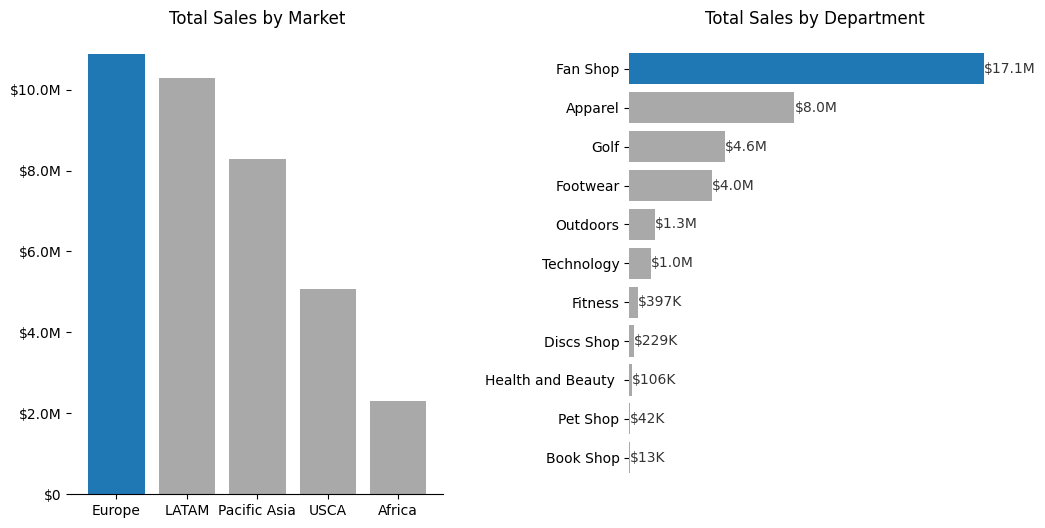

In [11]:
# Get the top markets and departments
top_markets = dict(sorted(market_sales.items(), key=lambda item: item[1], reverse=True)[:1])
top_department = "Fan Shop"

# Define a currency formatter function
def currency_formatter(x, pos):
    if x >= 1e9:
        return "${:,.1f}B".format(x / 1e9)
    elif x >= 1e6:
        return "${:,.1f}M".format(x / 1e6)
    elif x >= 1e3:
        return "${:,.0f}K".format(x / 1e3)
    else:
        return "${:,.0f}".format(x)

# Create the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sales by market
for market, sales in market_sales.items():
    color = "tab:blue" if market in top_markets else "darkgrey"
    ax[0].bar(market, sales, color=color)

ax[0].set_title("Total Sales by Market")
ax[0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Plot sales by department
for department, sales in department_sales.items():
    color = "tab:blue" if department == top_department else "darkgrey"
    barh = ax[1].barh(department, sales, color=color)
    ax[1].text(sales, department, currency_formatter(sales, None),
               va="center", ha="left", color="black", alpha=0.8)

ax[1].set_title("Total Sales by Department")
ax[1].xaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax[1].spines["bottom"].set_visible(False)
ax[1].xaxis.set_visible(False)

for axes in ax:
    axes.spines[["top", "right", "left"]].set_visible(False)
    axes.set_axisbelow(True)

plt.subplots_adjust(wspace=0.5)
plt.show()

Europe and Latin America (LATAM) seem to be larger markets compared to all other regions combined. Let's look at it on an annual basis.

In [12]:
df.pivot_table(index="Year", columns="Market", values="Sales", aggfunc="sum")

Market,Africa,Europe,LATAM,Pacific Asia,USCA
Year,,,,,
2015,NaN,4.913405e+06,5.072188e+06,2.355238e+06,NaN
2016,2.046623e+06,7.613233e+05,NaN,4.452406e+06,5.043466e+06
2017,2.478302e+05,5.197668e+06,5.205424e+06,1.134450e+06,2.306319e+04
2018,NaN,NaN,NaN,3.316501e+05,NaN


According to the table; 

- The company entered the **African** market in 2016.
- The company stopped its operations in **LATAM** in 2016 and restarted them in 2017.
- The company entered the **USCA** market in 2016.

To maintain consistency, we can only consider **2017** for inventory management processes.


In [13]:
df_ = df[(df["Year"] == 2017)]

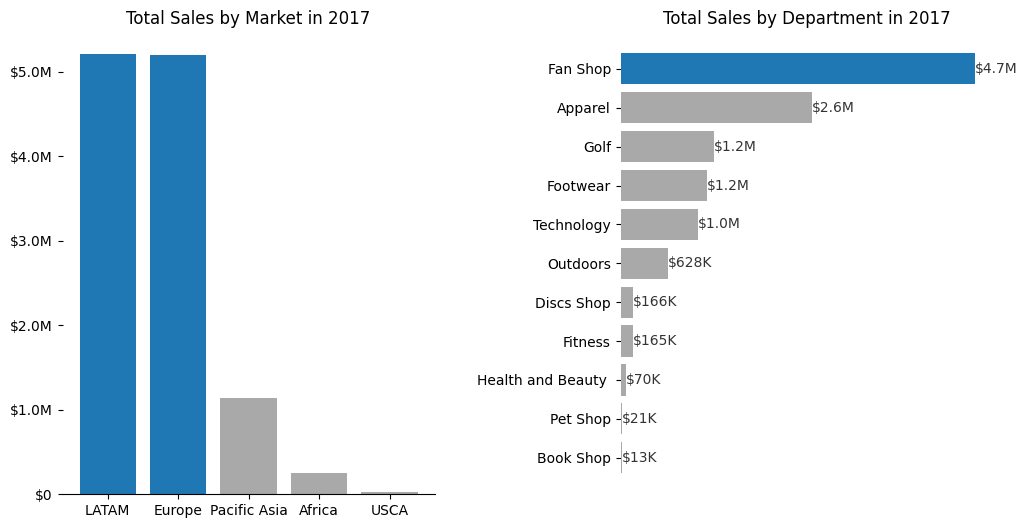

In [14]:
market_sales_2017 = df_.groupby("Market")["Sales"].sum().sort_values(ascending=False)
department_sales_2017 = df_.groupby("Department Name",observed=False)["Sales"].sum().sort_values(ascending=True)

top_markets_2017 = dict(sorted(market_sales_2017.items(), key=lambda item: item[1], reverse=True)[:2])
top_department_2017 = "Fan Shop"

# Create the figure and subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot sales by market
for market, sales in market_sales_2017.items():
    color = "tab:blue" if market in top_markets_2017 else "darkgrey"
    ax[0].bar(market, sales, color=color)

ax[0].set_title("Total Sales by Market in 2017")
ax[0].yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Plot sales by department
for department, sales in department_sales_2017.items():
    color = "tab:blue" if department == top_department_2017 else "darkgrey"
    barh = ax[1].barh(department, sales, color=color)
    ax[1].text(sales, department, currency_formatter(sales, None),
               va="center", ha="left", color="black", alpha=0.8)

ax[1].set_title("Total Sales by Department in 2017")
ax[1].xaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax[1].spines["bottom"].set_visible(False)
ax[1].xaxis.set_visible(False)

for axes in ax:
    axes.spines[["top", "right", "left"]].set_visible(False)
    axes.set_axisbelow(True)

plt.subplots_adjust(wspace=0.5)
plt.show()

LATAM and Europe appear to be the largest markets in terms of sales, followed by Pacific Asia, Africa, and USCA.

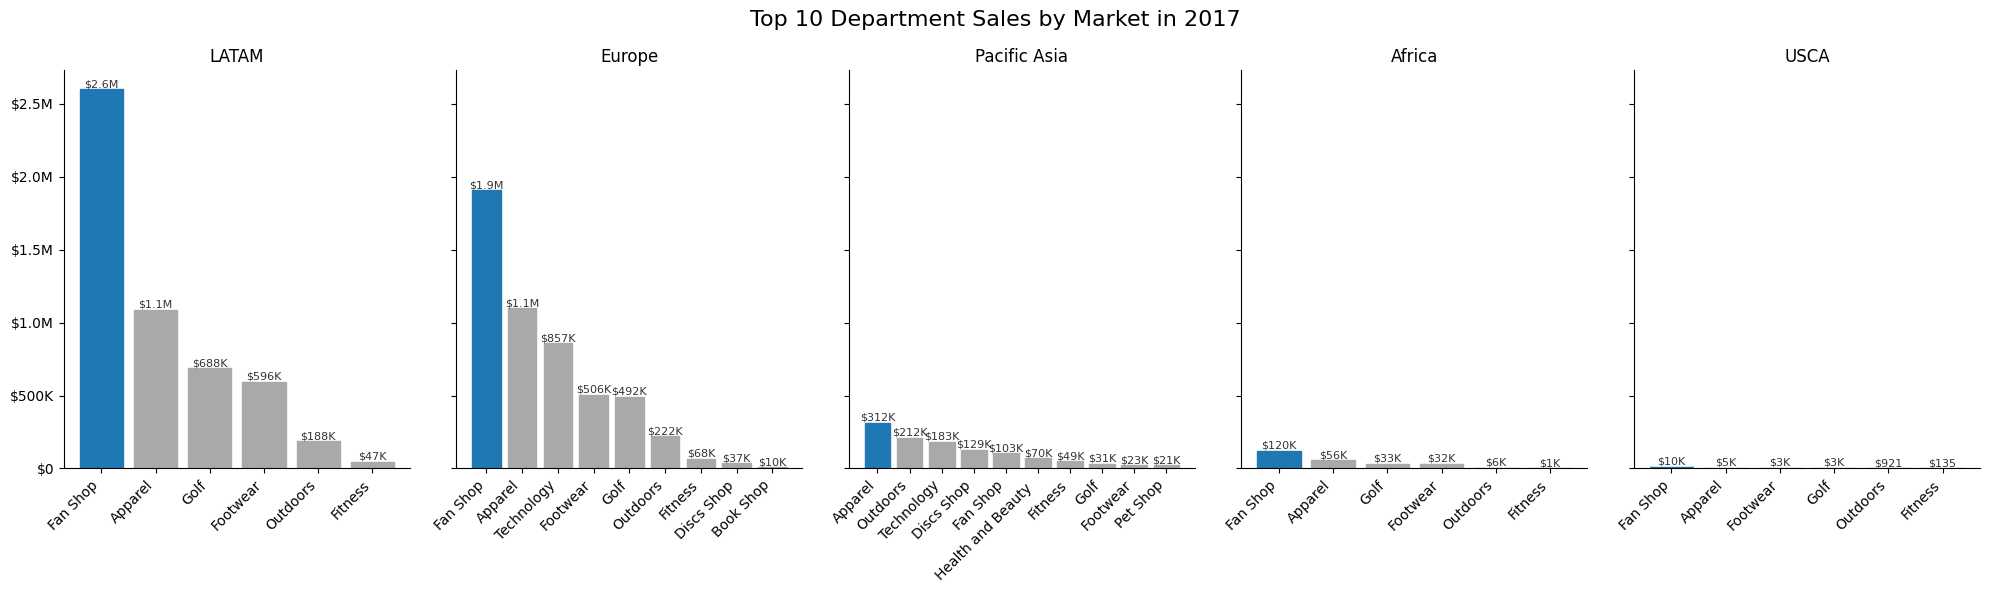

In [15]:
market_sales_idx = df_.groupby("Market")["Sales"].sum().sort_values(ascending=False).index
total_sales_by_market_department = df_.groupby(["Market","Department Name"])["Sales"].sum().reset_index()
top5_departments = total_sales_by_market_department.groupby("Market").apply(lambda x: x.nlargest(10, "Sales")).reset_index(drop=True)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6),sharey=True)

for ax, market in zip(axs, market_sales_idx):
    data = top5_departments[top5_departments["Market"] == market]
    max_sales_department = data.loc[data["Sales"].idxmax()]
    bars=ax.bar(data["Department Name"], data["Sales"])
    for bar in bars:
        if bar.get_height() == max_sales_department["Sales"]:
            bar.set_color("tab:blue")
        else:
            bar.set_color("darkgray")
    

    ax.set_title(market)
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    ax.spines[["top","right"]].set_visible(False)
  

    for i, (index, row) in enumerate(data.iterrows()):
        # Use the index of the bar as the x-coordinate
        ax.text(i, row["Sales"], currency_formatter(row["Sales"],None), va="bottom", ha="center", color="black", alpha=0.8,fontsize=8)
    ax.set_axisbelow(False)
    ax.set_xticklabels(data["Department Name"], rotation=45, ha="right")
fig.suptitle("Top 10 Department Sales by Market in 2017",fontsize=16)
plt.tight_layout()
plt.show()



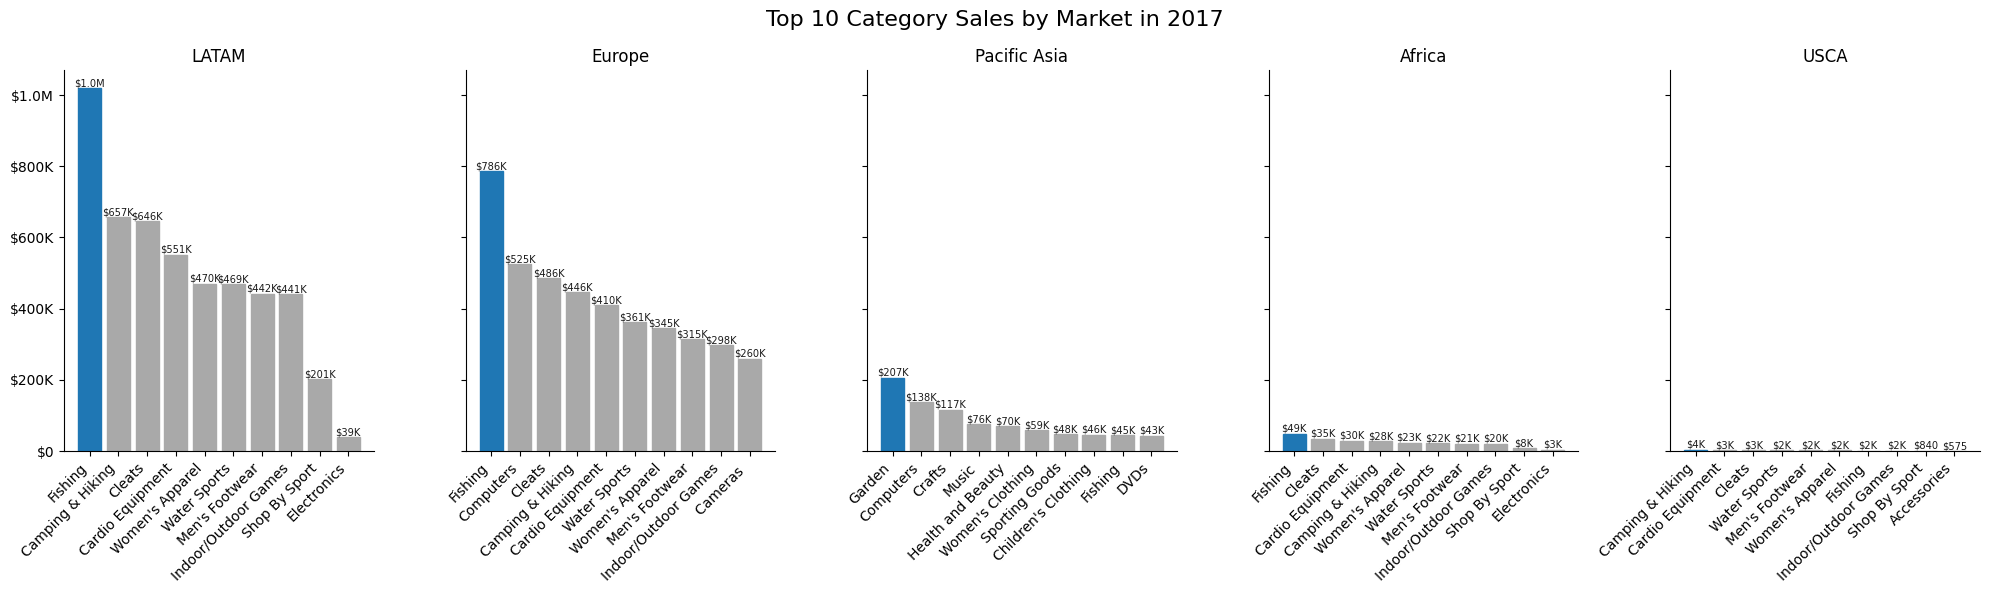

In [16]:
total_sales_by_market_category = df_.groupby(["Market","Category Name"])["Sales"].sum().reset_index()

top5_departments = total_sales_by_market_category.groupby("Market").apply(lambda x: x.nlargest(10, "Sales")).reset_index(drop=True)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6),sharey=True)

for ax, market in zip(axs, market_sales_idx):
    data = top5_departments[top5_departments["Market"] == market]
    max_sales_category = data.loc[data["Sales"].idxmax()]
    bars=ax.bar(data["Category Name"], data["Sales"])
    for bar in bars:
        if bar.get_height() == max_sales_category["Sales"]:
            bar.set_color("tab:blue")
        else:
            bar.set_color("darkgray")
    
    ax.set_title(market)
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    ax.spines[["top","right"]].set_visible(False)

    for i, (index, row) in enumerate(data.iterrows()):
        # Use the index of the bar as the x-coordinate
        ax.text(i, row["Sales"], currency_formatter(row["Sales"],None), va="bottom", ha="center", color="black", alpha=0.9,fontsize=7.1)
    ax.set_axisbelow(False)
    ax.set_xticklabels(data["Category Name"], rotation=45, ha="right")
fig.suptitle("Top 10 Category Sales by Market in 2017",fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
def quantity_formatter(x,pos):
    if x >= 1e9:
        return "{:,.1f}B".format(x / 1e9)
    elif x >= 1e6:
        return "{:,.1f}M".format(x / 1e6)
    elif x >= 1e3:
        return "{:,.0f}K".format(x / 1e3)
    else:
        return "{:,.0f}".format(x)

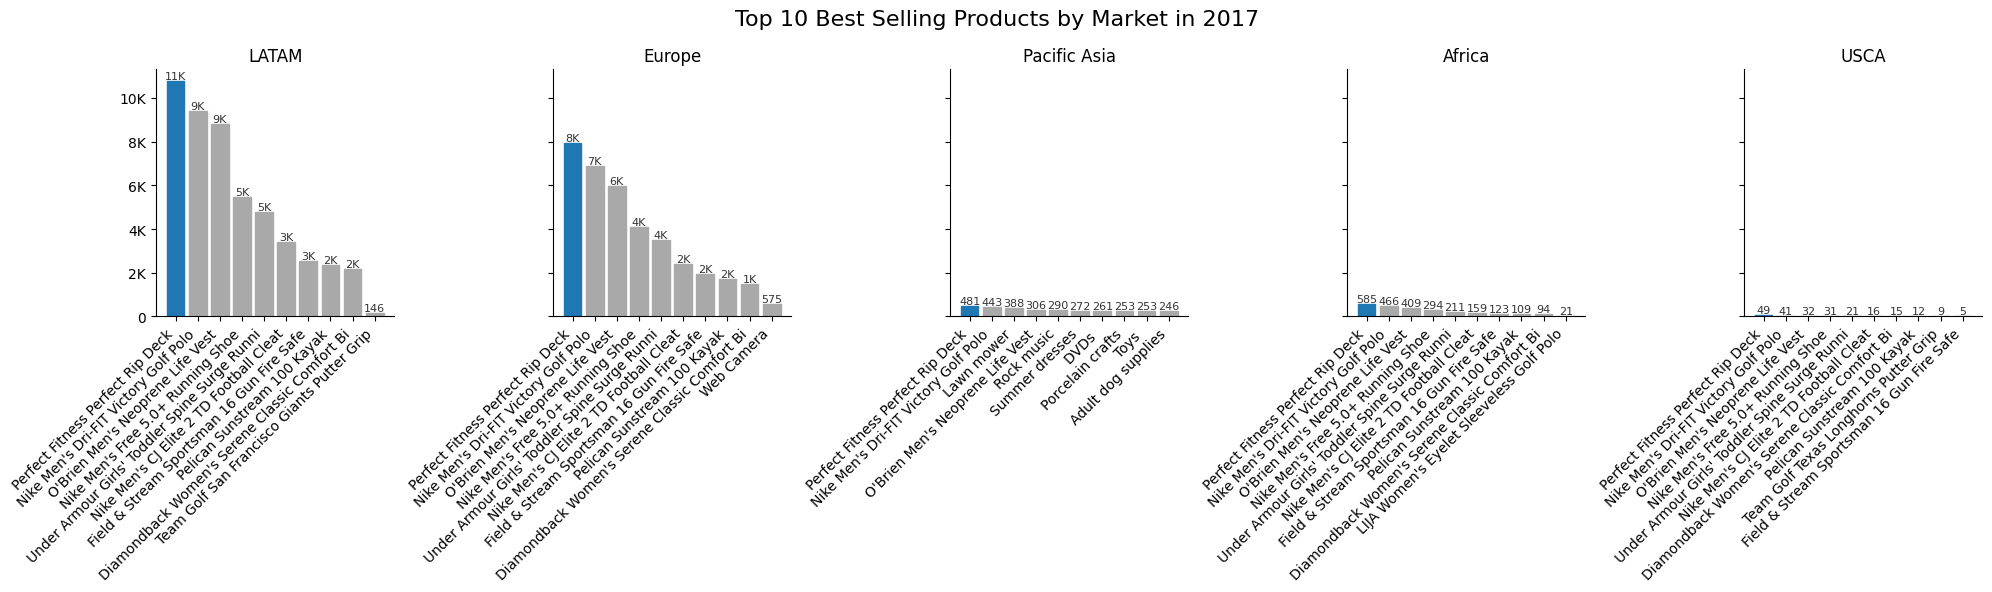

In [18]:
market_order_idx = df_.groupby("Market")["Order Item Quantity"].sum().sort_values(ascending=False).index
total_order_by_market_product = df_.groupby(["Market","Product Name"])["Order Item Quantity"].sum().reset_index()

top10_product = total_order_by_market_product.groupby("Market").apply(lambda x: x.nlargest(10, "Order Item Quantity")).reset_index(drop=True)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 6),sharey=True)

for ax, market in zip(axs, market_order_idx):
    data = top10_product[top10_product["Market"] == market]
    max_order_product = data.loc[data["Order Item Quantity"].idxmax()]
    bars=ax.bar(data["Product Name"], data["Order Item Quantity"])
    for bar in bars:
        if bar.get_height() == max_order_product["Order Item Quantity"]:
            bar.set_color("tab:blue")
        else:
            bar.set_color("darkgray")
    
    ax.set_title(market)
    ax.yaxis.set_major_formatter(FuncFormatter(quantity_formatter))
    ax.spines[["top","right"]].set_visible(False)

    for i, (index, row) in enumerate(data.iterrows()):
        # Use the index of the bar as the x-coordinate
        ax.text(i, row["Order Item Quantity"], quantity_formatter(row["Order Item Quantity"],None), va="bottom", ha="center", color="black", alpha=0.8,fontsize=8)
    ax.set_axisbelow(False)
    ax.set_xticklabels(data["Product Name"], rotation=45, ha="right")
fig.suptitle("Top 10 Best Selling Products by Market in 2017",fontsize=16)
plt.tight_layout()
plt.show()

The 'Perfect Fitness Perfect Rip Deck' is the top-selling product in all markets. LATAM market shows higher performance in terms of order quantity compared to other markets.

In [19]:
df_.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State',
       'Customer Street', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'order date (DateOrders)',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Name', 'Product Price', 'Product Status',
       'shipping date (DateOrders)', 'Shipping Mode', 'Year'],
      dtype='object')

### Creating World Map with Geopandas

In [20]:
all_countries_sales = df_.groupby(["Order Country"])["Sales"].sum().reset_index()
all_cities_sales = df_.groupby(["Order City"])["Sales"].sum().reset_index()
all_order_region_sales = df_.groupby(["Order Region"])["Sales"].sum().reset_index()

In [21]:
all_countries_sales[all_countries_sales["Order Country"]=="Brasil"]

,Order Country,Sales
17,Brasil,801994.765935


In [22]:
all_countries_sales.shape

(129, 2)

In [23]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [24]:
world[world["name"]=="Brazil"]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
29,211049527.0,South America,Brazil,BRA,1839758,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."


Country names do not match. Let's see which countries don't match.

In [25]:
unmatched_countries = set(all_countries_sales["Order Country"]).difference(set(world["name"]))

In [26]:
unmatched_countries

{'Afganistán',
 'Alemania',
 'Arabia Saudí',
 'Argelia',
 'Azerbaiyán',
 'Bangladés',
 'Barbados',
 'Belice',
 'Benín',
 'Bielorrusia',
 'Bosnia y Herzegovina',
 'Brasil',
 'Bután',
 'Bélgica',
 'Camboya',
 'Camerún',
 'Chipre',
 'Corea del Sur',
 'Costa de Marfil',
 'Croacia',
 'Dinamarca',
 'Egipto',
 'Eslovaquia',
 'España',
 'Filipinas',
 'Finlandia',
 'Francia',
 'Gabón',
 'Grecia',
 'Guadalupe',
 'Guayana Francesa',
 'Haití',
 'Hong Kong',
 'Hungría',
 'Irak',
 'Irlanda',
 'Irán',
 'Italia',
 'Japón',
 'Jordania',
 'Kazajistán',
 'Kenia',
 'Kirguistán',
 'Lituania',
 'Luxemburgo',
 'Líbano',
 'Macedonia',
 'Malasia',
 'Marruecos',
 'Martinica',
 'Moldavia',
 'Myanmar (Birmania)',
 'México',
 'Noruega',
 'Níger',
 'Pakistán',
 'Panamá',
 'Papúa Nueva Guinea',
 'Países Bajos',
 'Perú',
 'Polonia',
 'Reino Unido',
 'República Checa',
 'República Democrática del Congo',
 'República Dominicana',
 'Ruanda',
 'Rumania',
 'Rusia',
 'Singapur',
 'SudAfrica',
 'Suecia',
 'Suiza',
 'Surinam

In [27]:
mapping_dict = {
    'Afganistán': 'Afghanistan',
    'Alemania': 'Germany',
    'Arabia Saudí': 'Saudi Arabia',
    'Argelia': 'Algeria',
    'Azerbaiyán': 'Azerbaijan',
    'Bangladés': 'Bangladesh',
    'Barbados': 'Barbados',
    'Baréin': 'Bahrain',
    'Belice': 'Belize',
    'Benín': 'Benin',
    'Bielorrusia': 'Belarus',
    'Bosnia y Herzegovina': 'Bosnia and Herzegovina',
    'Botsuana': 'Botswana',
    'Brasil': 'Brazil',
    'Bután': 'Bhutan',
    'Bélgica': 'Belgium',
    'Camboya': 'Cambodia',
    'Camerún': 'Cameroon',
    'Chipre': 'Cyprus',
    'Corea del Sur': 'South Korea',
    'Costa de Marfil': 'Ivory Coast',
    'Croacia': 'Croatia',
    'Dinamarca': 'Denmark',
    'Egipto': 'Egypt',
    'Emiratos Árabes Unidos': 'United Arab Emirates',
    'Eslovaquia': 'Slovakia',
    'Eslovenia': 'Slovenia',
    'España': 'Spain',
    'Estados Unidos': 'United States of America',
    'Etiopía': 'Ethiopia',
    'Filipinas': 'Philippines',
    'Finlandia': 'Finland',
    'Francia': 'France',
    'Gabón': 'Gabon',
    'Grecia': 'Greece',
    'Guadalupe': 'Guadeloupe',
    'Guayana Francesa': 'French Guiana',
    'Guinea Ecuatorial': 'Equatorial Guinea',
    'Haití': 'Haiti',
    'Hong Kong': 'Hong Kong',
    'Hungría': 'Hungary',
    'Irak': 'Iraq',
    'Irlanda': 'Ireland',
    'Irán': 'Iran',
    'Italia': 'Italy',
    'Japón': 'Japan',
    'Jordania': 'Jordan',
    'Kazajistán': 'Kazakhstan',
    'Kenia': 'Kenya',
    'Kirguistán': 'Kyrgyzstan',
    'Lesoto': 'Lesotho',
    'Libia': 'Libya',
    'Lituania': 'Lithuania',
    'Luxemburgo': 'Luxembourg',
    'Líbano': 'Lebanon',
    'Macedonia': 'North Macedonia',
    'Malasia': 'Malaysia',
    'Marruecos': 'Morocco',
    'Martinica': 'Martinique',
    'Moldavia': 'Moldova',
    'Myanmar (Birmania)': 'Myanmar',
    'México': 'Mexico',
    'Noruega': 'Norway',
    'Nueva Zelanda': 'New Zealand',
    'Níger': 'Niger',
    'Omán': 'Oman',
    'Pakistán': 'Pakistan',
    'Panamá': 'Panama',
    'Papúa Nueva Guinea': 'Papua New Guinea',
    'Países Bajos': 'Netherlands',
    'Perú': 'Peru',
    'Polonia': 'Poland',
    'Reino Unido': 'United Kingdom',
    'República Centroafricana': 'Central African Republic',
    'República Checa': 'Czech Republic',
    'República Democrática del Congo': 'Democratic Republic of the Congo',
    'República Dominicana': 'Dominican Republic',
    'República de Gambia': 'The Gambia',
    'República del Congo': 'Republic of the Congo',
    'Ruanda': 'Rwanda',
    'Rumania': 'Romania',
    'Rusia': 'Russia',
    'Sierra Leona': 'Sierra Leone',
    'Singapur': 'Singapore',
    'Siria': 'Syria',
    'Suazilandia': 'Eswatini',
    'SudAfrica': 'South Africa',
    'Sudán': 'Sudan',
    'Sudán del Sur': 'South Sudan',
    'Suecia': 'Sweden',
    'Suiza': 'Switzerland',
    'Surinam': 'Suriname',
    'Sáhara Occidental': 'Western Sahara',
    'Tailandia': 'Thailand',
    'Taiwán': 'Taiwan',
    'Tayikistán': 'Tajikistan',
    'Trinidad y Tobago': 'Trinidad and Tobago',
    'Turkmenistán': 'Turkmenistan',
    'Turquía': 'Turkey',
    'Túnez': 'Tunisia',
    'Ucrania': 'Ukraine',
    'Uzbekistán': 'Uzbekistan',
    'Yibuti': 'Djibouti',
    'Zimbabue': 'Zimbabwe'
}

Let's replace them with their correct names.

In [28]:
all_countries_sales["Order Country"] = all_countries_sales["Order Country"].replace(mapping_dict)

Now we can merge the datasets.

In [29]:
world_sales = world.merge(all_countries_sales, left_on="name", right_on="Order Country")

In [30]:
world_sales.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Order Country,Sales
0,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,12913.420294
1,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,23063.190499
2,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,3589.650062
3,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",Uzbekistan,2642.630039
4,8776109.0,Oceania,Papua New Guinea,PNG,24829,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",Papua New Guinea,425.029999


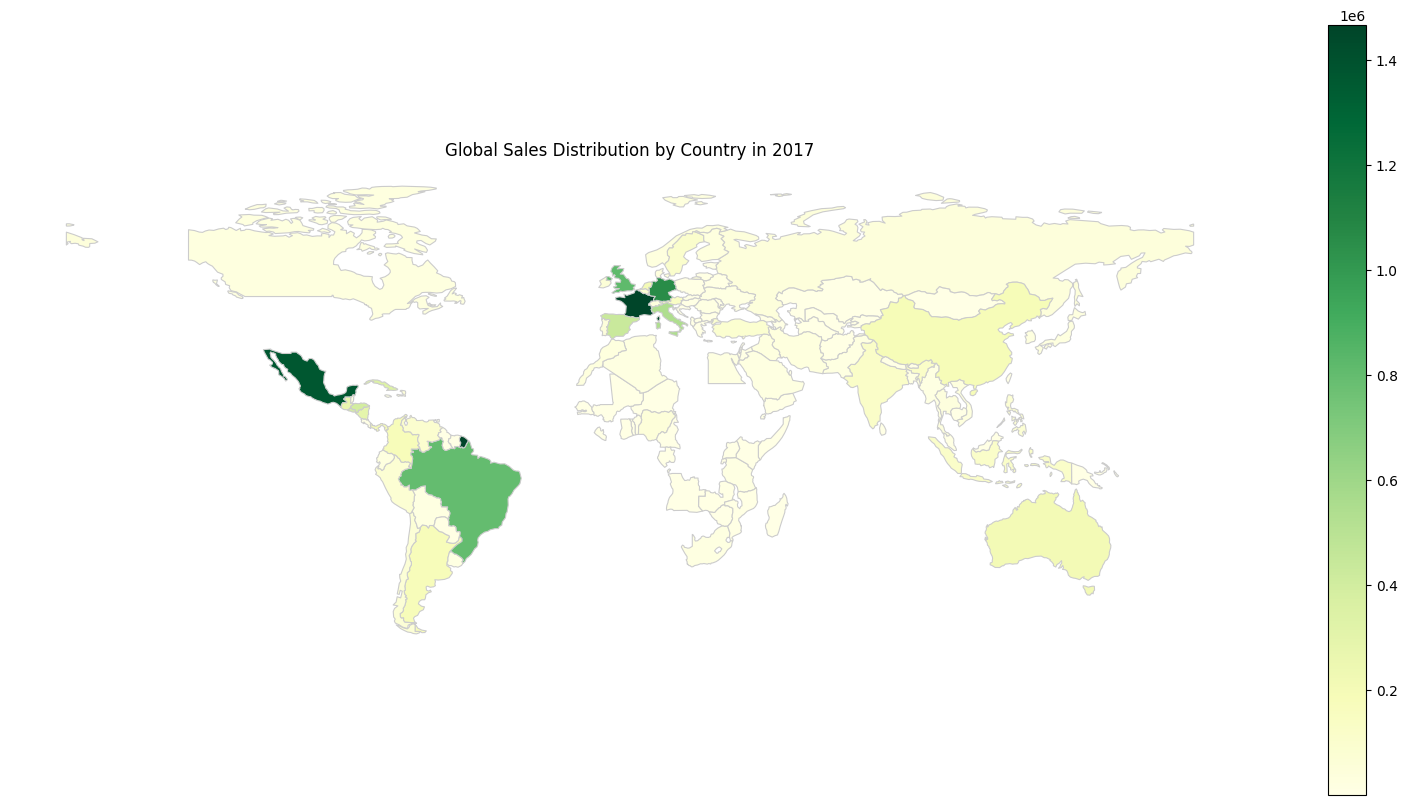

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))
world_sales.plot(column="Sales", cmap='YlGn', linewidth=0.8, edgecolor='0.8', legend=True,ax=plt.gca()).set_axis_off()

# Set the title and show the plot
plt.title("Global Sales Distribution by Country in 2017")
plt.show()

In [32]:
# Interactive version of the graph above.
# m = folium.Map(location=[0, 0], zoom_start=3,tiles="cartodb positron")

# folium.Choropleth(
#     geo_data=world_sales,
#     name="choropleth",
#     data=world_sales,
#     columns=["name", "Sales"],
#     key_on="feature.properties.name",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     nan_fill_color="white",
    
#     legend_name="Sales",
#      highlight=True,
    
# ).add_to(m)


# folium.GeoJson(
#     data=world_sales,
#     style_function=lambda feature: {
#         "color":"",
#         "weight": 0.2, 
#     },
#     tooltip=folium.GeoJsonTooltip(
#         fields=["name", "Sales"],
#         aliases=["Country:", "Sales: "],
#         labels=True,
#         sticky=True,
#         style="background-color: white;"
        
#         )
#     ).add_to(m)

# m

In [33]:
world_sales.groupby("Order Country")["Sales"].sum().reset_index(name="Sales").sort_values(by="Sales",ascending=False)[:10]

,Order Country,Sales
34,France,1.466954e+06
65,Mexico,1.371471e+06
37,Germany,1.064684e+06
110,United Kingdom,8.170683e+05
15,Brazil,8.019948e+05
51,Italy,5.422939e+05
96,Spain,4.334722e+05
43,Honduras,3.942301e+05
31,El Salvador,3.758007e+05
25,Cuba,3.386557e+05


Let's check the store's location.

In [34]:
# Load the shapefile containing the boundaries of US states
us_states = gpd.read_file('data\states.shp')

In [35]:
# Group the data by longitude and latitude to count the number of stores at each location
stores_count = df_.groupby(["Longitude","Latitude"]).size().reset_index(name="Store_Counts")

In [36]:
# We need to create Point(longitude,latitude) from Store_count.
# Create a list of Point geometries based on longitude and latitude coordinates
geometry = [Point(xy) for xy in zip(stores_count["Longitude"], stores_count["Latitude"])]

# Add the Point geometries to the stores_count DataFrame as a new column named "point_geometry"
stores_count["point_geometry"] = geometry

In [37]:
# Create a GeoDataFrame from the stores_count DataFrame with Point geometries and EPSG:4326 CRS
stores_gdf = gpd.GeoDataFrame(stores_count, geometry="point_geometry",crs="EPSG:4326")

Stores are mainly in the US, with some outliers.

In [38]:
# Create a GeoDataFrame containing only stores that are within the boundaries of the USA states
stores_gdf_usa = stores_gdf[stores_gdf.within(us_states.unary_union)]

In [39]:
# Perform a spatial join between the GeoDataFrame of stores within the USA and the GeoDataFrame of USA states
gdf_with_states = gpd.sjoin(stores_gdf_usa, us_states, op="within")

In [40]:
# Aggregate store counts by state
state_counts = gdf_with_states.groupby("STATE_NAME")["Store_Counts"].sum().reset_index()

In [41]:
merged_states_counts= pd.merge(us_states, state_counts, on="STATE_NAME")

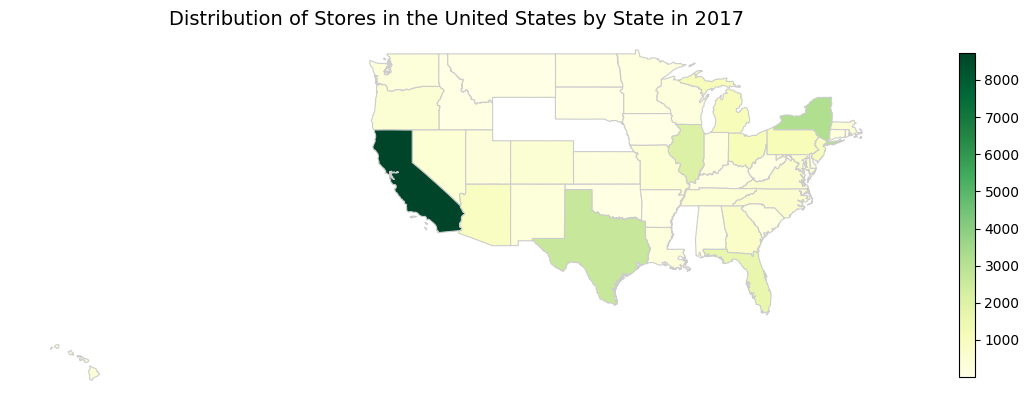

In [42]:
fig, ax = plt.subplots(figsize=(18, 14))

merged_states_counts.plot(column="Store_Counts", cmap='YlGn', linewidth=0.8, edgecolor='0.8', legend=True,ax=ax).set_axis_off()
cbar = ax.get_figure().colorbar(ax.collections[0], shrink=0.3) 
old_cbar = ax.get_figure().get_axes()[1]  
old_cbar.remove() 
# Set the title and show the plot
plt.title("Distribution of Stores in the United States by State in 2017", fontdict={'fontsize': '14', 'fontweight' : '1'})
plt.show()

It seems that all the customers are located within the US, however, the orders are shipped worldwide. This indicates that the company might be an online shop, where stores across the US are selling their goods online to customers all over the world.

In [43]:
# Interactive version of the graph above
# f = folium.Map(location=[37, -95], zoom_start=5,tiles="cartodb positron")

# folium.Choropleth(
#     geo_data=merged_states_counts,
#     name="choropleth",
#     data=merged_states_counts,
#     columns=["STATE_NAME", "Store_Counts"],
#     key_on="feature.properties.STATE_NAME",
#     fill_color="YlGn",
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     nan_fill_color="white",
    
#     legend_name="Store_Counts",
#      highlight=True,
    
# ).add_to(f)
# f

Let's examine how numerical data is distributed

In [44]:
numerical_df = df_.select_dtypes(include=["int64","float64"])

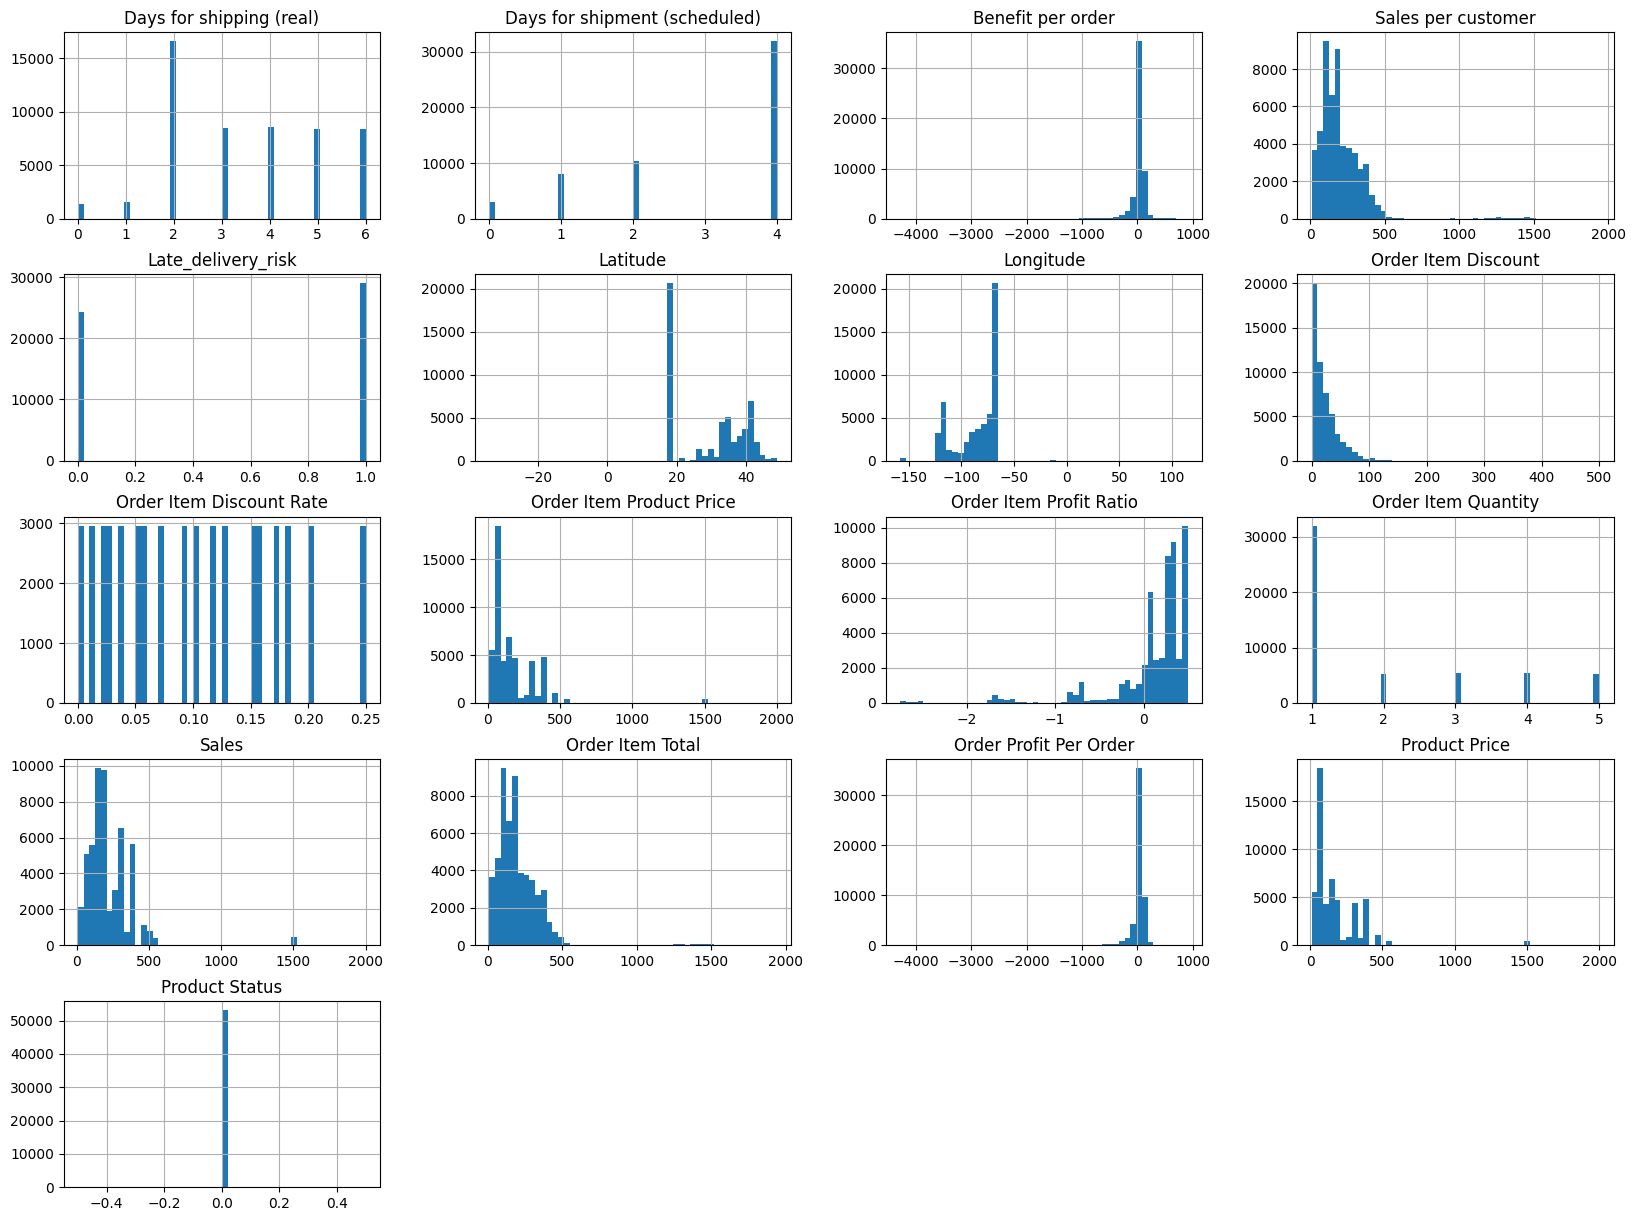

In [45]:
fig, ax = plt.subplots(figsize=(20, 15))
numerical_df.hist(ax=ax, bins=50)
plt.show()

The delivery time for most orders was 4 days, but orders were delivered in 2 days.
Most other distributions are skewed to the right.

In [46]:
df_.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State',
       'Customer Street', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'order date (DateOrders)',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Name', 'Product Price', 'Product Status',
       'shipping date (DateOrders)', 'Shipping Mode', 'Year'],
      dtype='object')

### Clustering the SKUs

First, to cluster the SKUs, the data needs to be aggregated so that only one row per SKU is obtained.

**What is SKU?**

"SKU" stands for Stock Keeping Unit. It's a term used as a stock tracking unit, commonly in retail sales. It serves as a unique identifier for a product. SKUs can include information about product specifications, supplier details, prices, and they are often readable via barcodes. Businesses such as stores and online sales platforms use SKUs for inventory management and sales tracking purposes.

There are different approaches and methods for segmentation. We will use the inventory management approach. Clustering groups similar SKUs, while ABC Classification emphasizes important SKUs for inventory management strategies.

In [47]:
clustering_features = [
    "Product Name",
    "Order Item Discount",
    "Order Item Discount Rate",
    "Order Item Product Price",
    "Order Item Profit Ratio",
    "Order Item Quantity",
    "Sales",
    "Order Item Total",
    "Order Profit Per Order",
    "Product Price",
    "order date (DateOrders)"
]

df_clustering = df_[clustering_features]

df_clustering_agg = (
    df_clustering.groupby("Product Name")
    .agg(
        {
            "Order Item Quantity": "sum",
            "Order Item Discount Rate": "mean",
            "Sales": "sum",
            "Order Item Profit Ratio": "mean",
        }
    )
    .reset_index()
)

In [48]:
df_clustering_agg.head()

,Product Name,Order Item Quantity,Order Item Discount Rate,Sales,Order Item Profit Ratio
0,Adult dog supplies,246,0.099634,20762.400376,0.094837
1,Baby sweater,207,0.104300,12229.560379,0.139420
2,Bag Boy Beverage Holder,98,0.109143,2449.019973,0.249429
3,Bag Boy M330 Push Cart,208,0.103623,16637.919929,0.184493
4,Bowflex SelectTech 1090 Dumbbells,10,0.138000,5999.899902,0.233000


In [49]:
df_clustering_agg.shape

(118, 5)

The company provides customers with a selection of 118 various products.

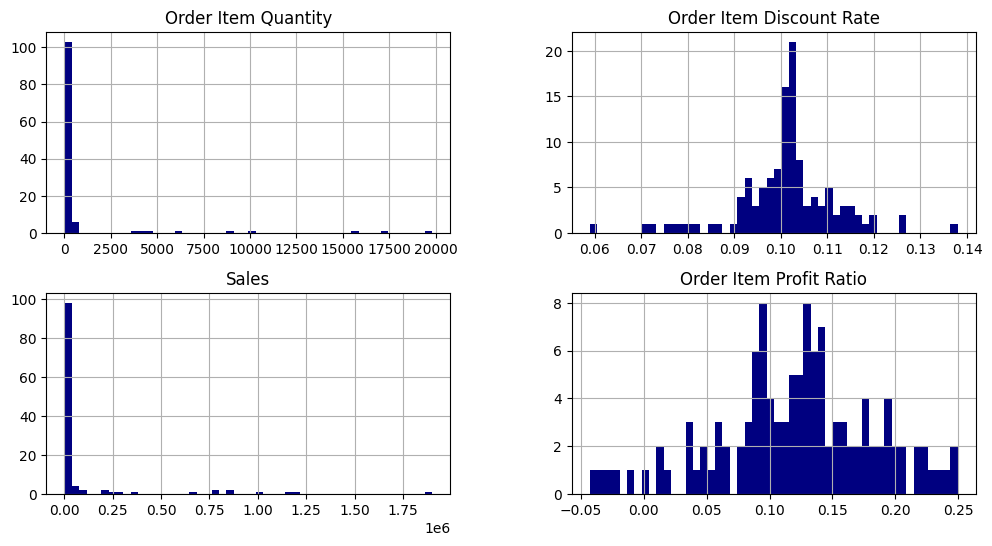

In [50]:
df_clustering_agg.hist(figsize=(12,6),bins=50,color='navy');

Most SKUs are rarely sold, but eight SKUs have very high sales volume, indicating that some of the company's products are very popular. To see this more clearly, let's look at it on a pareto chart.

In [51]:
df_cluster_sorted_order = df_clustering_agg.sort_values(by="Order Item Quantity",ascending=False).reset_index(drop=True)

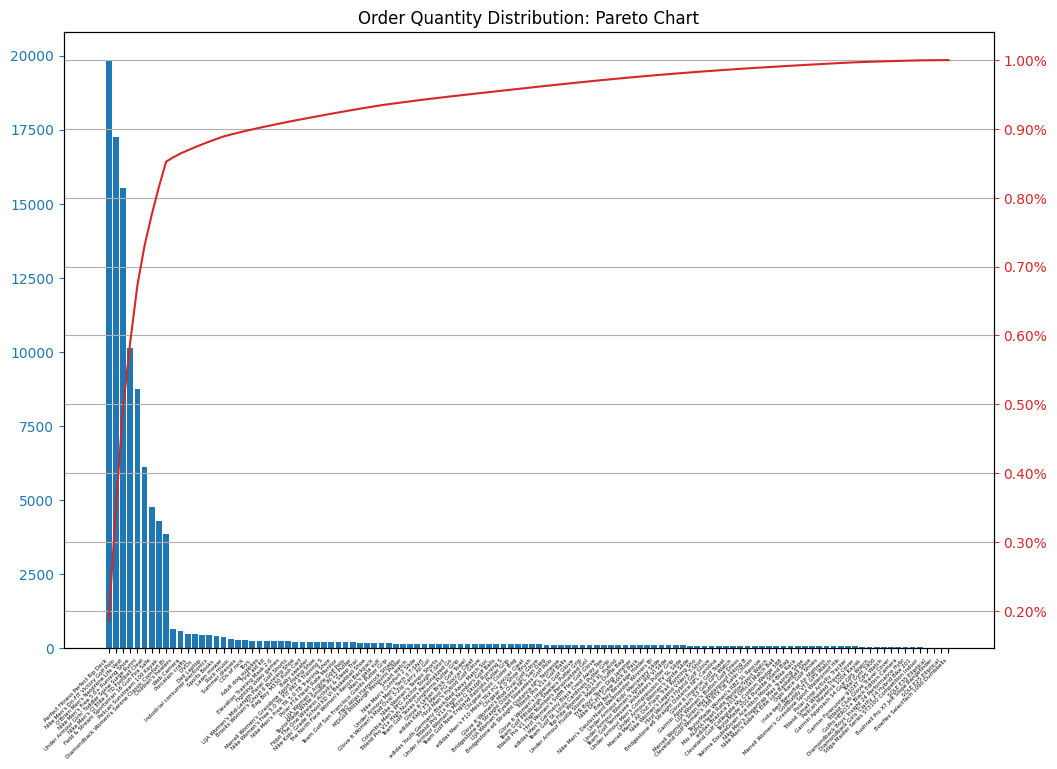

In [52]:
df_cluster_sorted_order["cum_quantity_perc"] = df_cluster_sorted_order["Order Item Quantity"].cumsum() / df_cluster_sorted_order["Order Item Quantity"].sum()

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(df_cluster_sorted_order["Product Name"],df_cluster_sorted_order["Order Item Quantity"]);
ax.set_xticklabels(df_cluster_sorted_order["Product Name"], rotation=45, ha="right",fontsize=4)
ax.set_title("Order Quantity Distribution: Pareto Chart")


ax2 = ax.twinx()
ax2.plot(df_cluster_sorted_order["Product Name"], df_cluster_sorted_order["cum_quantity_perc"], color="tab:red")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(axis="y")
ax2.set_axisbelow(True)

ax.tick_params(axis="y", colors="tab:blue")
ax2.tick_params(axis="y", colors="tab:red")

plt.show()

As seen in the graph above, only nine out of 118 SKUs accounted for almost 85% of the total order quantity.

In [53]:
# Total order quantity of 9 out of 118 SKUs
df_cluster_sorted_order.head(9)

,Product Name,Order Item Quantity,Order Item Discount Rate,Sales,Order Item Profit Ratio,cum_quantity_perc
0,Perfect Fitness Perfect Rip Deck,19807,0.101641,1.188222e+06,0.135466,0.186640
1,Nike Men's Dri-FIT Victory Golf Polo,17257,0.101407,8.628500e+05,0.128004,0.349252
2,O'Brien Men's Neoprene Life Vest,15530,0.101722,7.761894e+05,0.127727,0.495590
3,Nike Men's Free 5.0+ Running Shoe,10122,0.101597,1.012099e+06,0.126268,0.590969
4,Under Armour Girls' Toddler Spine Surge Runni,8739,0.101426,3.494726e+05,0.105432,0.673316
5,Nike Men's CJ Elite 2 TD Football Cleat,6126,0.101714,7.963188e+05,0.122739,0.731041
6,Field & Stream Sportsman 16 Gun Fire Safe,4751,0.101675,1.900305e+06,0.127076,0.775809
7,Pelican Sunstream 100 Kayak,4281,0.101738,8.561572e+05,0.120500,0.816149
8,Diamondback Women's Serene Classic Comfort Bi,3867,0.101730,1.160023e+06,0.100864,0.852588


Let's look at the pareto chart for “Sales”.

In [54]:
df_cluster_sorted_sales = df_clustering_agg.sort_values(by="Sales",ascending=False).reset_index(drop=True)

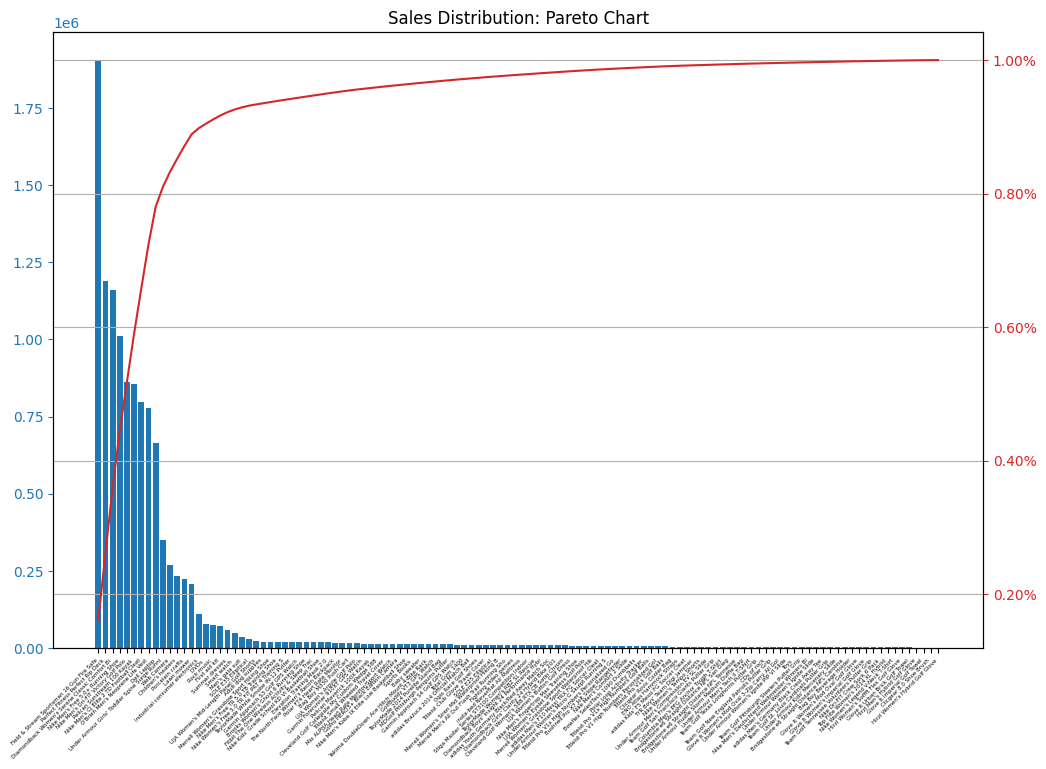

In [55]:
df_cluster_sorted_sales["cum_sales_perc"] = df_cluster_sorted_sales["Sales"].cumsum() / df_cluster_sorted_sales["Sales"].sum()

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(df_cluster_sorted_sales["Product Name"],df_cluster_sorted_sales["Sales"]);
ax.set_xticklabels(df_cluster_sorted_sales["Product Name"], rotation=45, ha="right",fontsize=4)
ax.set_title("Sales Distribution: Pareto Chart")


ax2 = ax.twinx()
ax2.plot(df_cluster_sorted_sales["Product Name"], df_cluster_sorted_sales["cum_sales_perc"], color="tab:red")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.grid(axis="y")
ax2.set_axisbelow(True)
ax.tick_params(axis="y", colors="tab:blue")
ax2.tick_params(axis="y", colors="tab:red")

plt.show()

The same interpretation can be made for sales value. Only nine SKUs contribute around 80% of the total sales value over the observed period.

In [56]:
# Total sales of 9 out of 118 SKUs
df_cluster_sorted_sales.head(9)

,Product Name,Order Item Quantity,Order Item Discount Rate,Sales,Order Item Profit Ratio,cum_sales_perc
0,Field & Stream Sportsman 16 Gun Fire Safe,4751,0.101675,1.900305e+06,0.127076,0.160928
1,Perfect Fitness Perfect Rip Deck,19807,0.101641,1.188222e+06,0.135466,0.261553
2,Diamondback Women's Serene Classic Comfort Bi,3867,0.101730,1.160023e+06,0.100864,0.359789
3,Nike Men's Free 5.0+ Running Shoe,10122,0.101597,1.012099e+06,0.126268,0.445499
4,Nike Men's Dri-FIT Victory Golf Polo,17257,0.101407,8.628500e+05,0.128004,0.518570
5,Pelican Sunstream 100 Kayak,4281,0.101738,8.561572e+05,0.120500,0.591074
6,Nike Men's CJ Elite 2 TD Football Cleat,6126,0.101714,7.963188e+05,0.122739,0.658510
7,O'Brien Men's Neoprene Life Vest,15530,0.101722,7.761894e+05,0.127727,0.724242
8,Dell Laptop,442,0.102240,6.630000e+05,0.117059,0.780388


#### Combination of ABCXYZ-Classification

##### ABC Classification:
- ABC classification is a method based on the Pareto Principle. It categorizes items in inventory into three categories: A, B, and C, based on their importance in terms of value or usage.
- Categories:
  - A: High-value or high-usage items requiring close monitoring.
  - B: Moderate-value or moderate-usage items managed with standard control.
  - C: Low-value or low-usage items managed with minimal attention.

##### XYZ Classification:
- Categorizes items based on demand variability or predictability.
- Categories:
  - X: Items with stable and predictable demand.
  - Y: Items with moderate variability in demand.
  - Z: Items with highly unpredictable demand.

##### Combining ABCXYZ-Classification:
- Provides a comprehensive view of inventory.
- Example: AX might be a high-value product with stable demand, needing tight control and accurate forecasting.
- Example: CZ might be a low-value product with highly unpredictable demand, requiring less control but more safety stock.

This approach helps businesses focus their resources on the most valuable items (A) while spending less time on less critical ones (C), saving time and money. It also helps reduce inventory holding costs and prevent stockouts by considering demand variability.

In [57]:
df_abc = df_cluster_sorted_sales[["Product Name", "Sales"]]

# Calculate cumulative sum of Sales and add it as a new column
df_abc["cum_sum"] = df_abc["Sales"].cumsum()

# Calculate cumulative percentage of Sales and add it as a new column
df_abc["cum_per"] = df_abc["cum_sum"] / df_abc["Sales"].sum() * 100

# Add the percentage of each SKU as a new column
df_abc["per"] = df_abc["cum_per"] - df_abc["cum_per"].shift(1)

# Add the first missing value in column "per" to be the first of cumulative percentage
df_abc.loc[0, "per"] = df_abc["cum_per"][0]

In [58]:
# Define function to classify the SKUs based on their cumlated percentage revenue
def abc_classification(data):
    if data["cum_per"] <= 70:
        return "A"
    elif data["cum_per"] > 70 and data["cum_per"] <= 95:
        return "B"
    elif data["cum_per"] > 95:
        return "C"

In [59]:
df_abc["Category"] = df_abc.apply(abc_classification, axis=1)

abc_summary = df_abc[["Category","Product Name","Sales"]].groupby("Category").agg(Revenue=("Sales","sum"),count=("Product Name","count"))

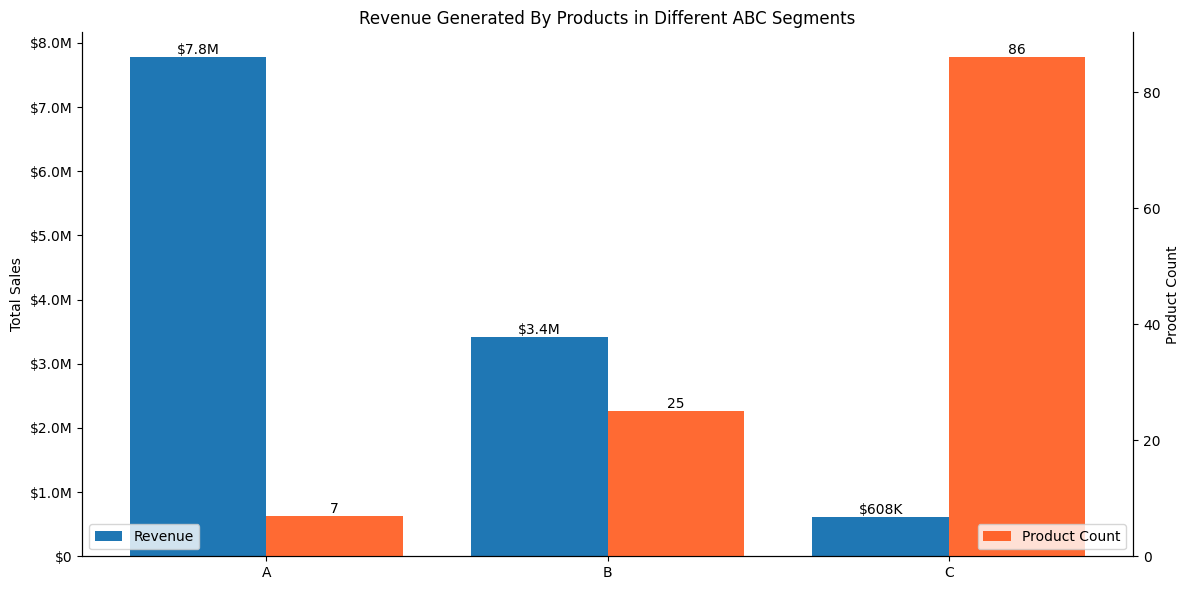

In [60]:
# Function to display bar values
def display_bar_values(bars, ax, formatter=None):
    for bar in bars:
        height = bar.get_height()
        # Apply the formatter if provided
        if formatter:
            formatted_height = formatter(height)
        else:
            formatted_height = str(height)
        ax.text(bar.get_x() + bar.get_width()/2, height,
                formatted_height, ha="center", va="bottom")
        
# Wrap currency_formatter to accept a single argument
def currency_formatter_wrapper(x):
    return currency_formatter(x, 0) 

fig, ax = plt.subplots(figsize=(12,6))

cat_index=list(range(len(abc_summary.index)))
offset = 0.2
bar_width =0.4

# Plot 'Revenue' on the first y-axis
x_revenue = [i - offset for i in cat_index]
bars1=ax.bar(x_revenue, abc_summary["Revenue"], 0.4, label='Revenue', alpha=1, color="tab:blue")
ax.set_ylabel("Total Sales")
ax.set_xticks(range(len(abc_summary.index)))
ax.set_xticklabels(abc_summary.index)
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Create a secondary y-axis for the 'Product Count'
ax2 = ax.twinx()

# Plot 'Product Count' on the secondary y-axis
x_product_count = [i + offset for i in cat_index]
bars2 = ax2.bar(x_product_count, abc_summary["count"], 0.4, label='Product Count', alpha=0.8, color="orangered")
ax2.set_ylabel("Product Count")

# Set the title and legend
plt.title("Revenue Generated By Products in Different ABC Segments")
ax.legend(loc="lower left")
ax2.legend(loc="lower right")

# Hide the top and right spines
ax.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)


# Display values for 'Revenue' bars
display_bar_values(bars1, ax,formatter=currency_formatter_wrapper)

# Display values for 'Product Count' bars
display_bar_values(bars2, ax2)


# Adjust layout
plt.tight_layout()
plt.show()

- Only 7 products contribute around 70% of our total sales, while 86 contribute only 5%. These products are vital to our store, demanding a high level of service. Maintaining safety stock is imperative to ensure we never run out of them. It is important to have various suppliers for A-class products to prevent revenue loss and customer migration to competitors due to product shortages.
- The 25 products in category B contribute 28% of total sales. This category may represent products of medium importance. Procurement processes and inventory management may need to be planned more carefully.
- The 86 products in category C contribute around 5% of total sales. This category may represent lower value and more common products. Supply chain managers must continuously make improvements to optimize stock levels of these products and increase efficiency.
- Priority should be given to class A products when allocating capital and stocking space, followed by class B products. Class C products, which generate the least revenue, should have minimal inventory. With 86 products in Class C, excess inventory not only takes up significant stocking space but also ties up capital unnecessarily.
